# Computing the Euler characteristic and entropy from rs_fMRI data
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Introduction**
In this notebook, we compute the Euler characteristic, entropy and Betti numbers from simplicial complexes representing functional neural networks. The networks are constructed using rs-fMRI (resting-state functional magnetic resonance imaging) data.

## Importing data

**Import libraries**

In [13]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy.optimize import minimize

**Import data**

Generate an average connectivity matrix from the whole human connectome dataset.

In [4]:
# Importing all matrices with Numpy
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Generate an averaged matrix
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix
averaged_matrix = MatAv/len(matrices)

In [11]:
# Import TDA background functions
%run TDA.py

# Betti numbers, Euler Characteristic and entropy

**Betti numbers**

A set of topological invariants are the Betti numbers (𝛽). Given that a simplicial complex is a high-dimensional structure, 𝛽𝑘 counts the number of k-dimensional holes in the simplicial complex. These are topological invariants that correspond, for each 𝑘≥0, to the number of linearly independent k-dimensional holes in the simplicial complex.

In [20]:
# Compute a sparser graph (10%)
G_d10 = densthr(0.1, averaged_matrix)

# Compute Betti number
Betti_k(G_d10, 1)

13

In [21]:
# Compute a sparser graph (10% density)
G_d10 = densthr(0.1, averaged_matrix)
print(Betti_k(G_d10, 1))

# Compute a sparser graph (10% maximum correlation)
G_t10 = Graph_thresh(0.1, averaged_matrix)
print(Betti_k(G_t10, 1))

13
0


**Compute the Betti numbers for a given threshold/density interval**

In [10]:
# Density interval
Betti_list_d = []

for i in np.arange(0.01,0.4,0.2):
    G = densthr(i, averaged_matrix)
    Betti_number = Betti_k(G, 1)
    Betti_list_d.append(Betti_number)

print(Betti_list_d)

[2, 0]


In [9]:
# Threshold interval
Betti_list_t = []

for i in np.arange(0.5,0.7,0.1):
    G = Graph_thresh(i, averaged_matrix)
    Betti_number = Betti_k(G, 1)
    Betti_list_t.append(Betti_number)

print(Betti_list_t)

Check
Check
[2, 0]


**Euler Characteristic**

Another topological invariant is the Euler characteristic. From this value we can compute the Euler entropy of the network.

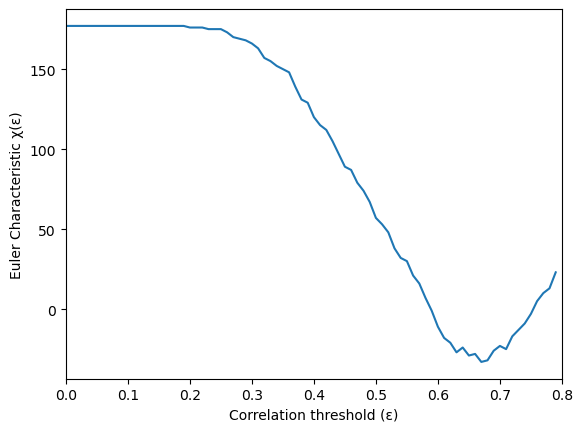

In [24]:
# Plot the Euler characteristic for a given threshold interval
i = averaged_matrix
maxvalue = 80
plt.plot(Eulerchoice_thr(i,maxvalue,0))
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler Characteristic χ(ε)')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

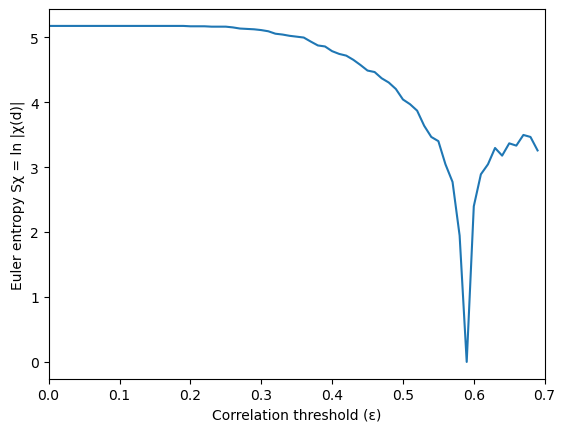

In [25]:
# Plot the Euler entropy for a given threshold interval
i = averaged_matrix
maxvalue = 70
plt.plot(np.log(np.abs(Eulerchoice_thr(i, maxvalue, 0))))
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler entropy Sχ = ln |χ(ε)|')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

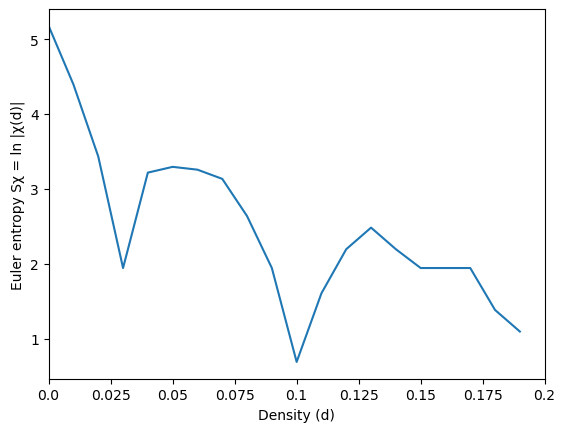

In [27]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation density level.
plotEuler_den(averaged_matrix, 20)

**Repeat entropy for individual brains and their average**

In [28]:
# Extended plot for the Euler entropy for a given threshold interval
data_size = 10 # amount of matrices
maxvalue = 60
entropy_list = []

for matrix in matrices[:data_size]:
    entropy = np.log(np.abs(Eulerchoice_thr(matrix, maxvalue, 0)))
    entropy_list.append(entropy)

average_entropy = [sum(x) / data_size for x in zip(*entropy_list)]

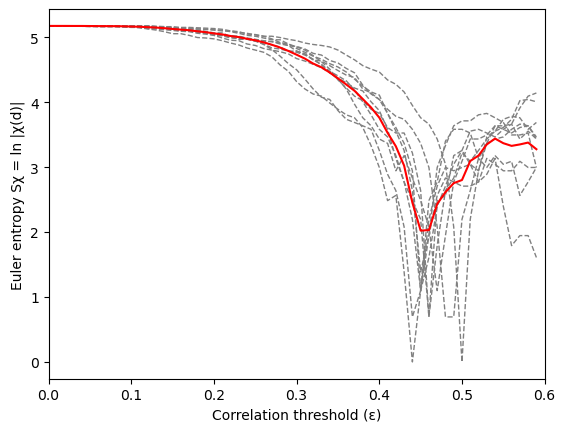

In [29]:
# Plot averaged entropy
for i in range(0, len(entropy_list)):
    plt.plot(entropy_list[i], color='grey', linestyle='--', linewidth=1)
plt.plot(average_entropy, 'r-')
plt.xlabel('Correlation threshold (ε)')
plt.ylabel('Euler entropy Sχ = ln |χ(ε)|')
locs, labels = plt.xticks()
plt.xticks(locs, list(locs/100))
plt.xlim(0, maxvalue)
plt.show()

**Compute maximum entropy to find proper pdf**
To get the proper distribution of probabilities, find the maximum pdf using optimization. Compare SLQD with Simulated Annealing. SA to prevent getting stuck in local minima. Test first with a random set of probabilities.

In [41]:
# Define the Shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return np.sum(probabilities * np.log(probabilities))

# Constraints for optimization
def constraint(probabilities):
    return np.sum(probabilities) - 1.0

# Maximum Entropy using SLSQP
def maximum_entropy(initial_probabilities):
    # Optimization setup
    cons = ({'type': 'eq', 'fun': constraint})
    bounds = [(0, 1) for _ in range(len(initial_probabilities))]

    # Perform optimization
    result = minimize(shannon_entropy, initial_probabilities, method='SLSQP', bounds=bounds, constraints=cons)

    return result.x, -result.fun

# Simulated Annealing Function
def simulated_annealing(initial_probabilities):
    # Optimization setup
    result = minimize(shannon_entropy, initial_probabilities, method='L-BFGS-B', bounds=[(0, 1) for _ in range(len(initial_probabilities))])

    return result.x, -result.fun

In [42]:
# Example initial probabilities
list_size = 100
num_runs = 100
entropies_slsqp = []
entropies_annealing = []

for _ in range(num_runs):
    initial_probabilities = np.array(np.random.rand(list_size))

    # Maximum Entropy using SLSQP
    optimized_probabilities_slsqp, max_entropy_slsqp = maximum_entropy(initial_probabilities)
    entropies_slsqp.append(max_entropy_slsqp)

    # Simulated Annealing
    optimized_probabilities_annealing, max_entropy_annealing = simulated_annealing(initial_probabilities)
    entropies_annealing.append(max_entropy_annealing)

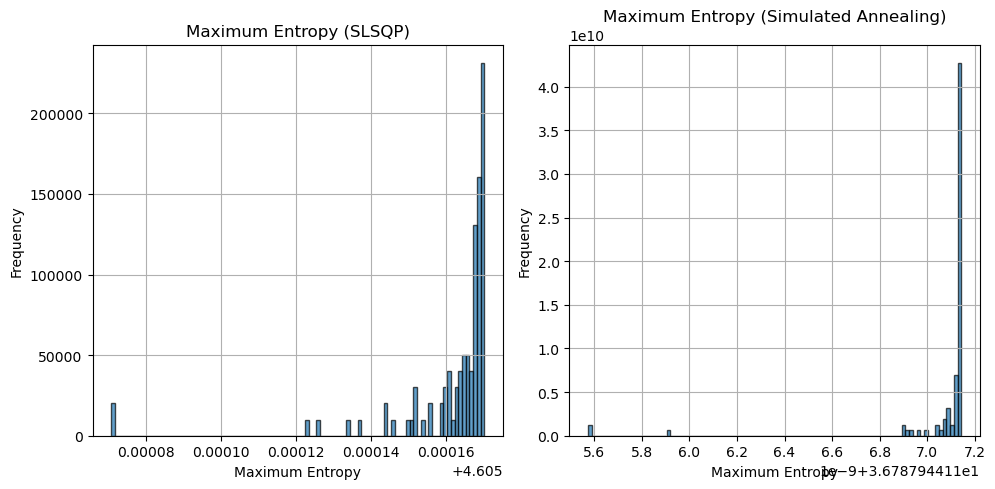

In [43]:
# Plotting the histograms side by side
plt.figure(figsize=(10, 5))

# Plotting SLSQP histogram
plt.subplot(1, 2, 1)
plt.hist(entropies_slsqp, bins=100, edgecolor='black', alpha=0.7, density=True, label='SLSQP')
plt.title('Maximum Entropy (SLSQP)')
plt.xlabel('Maximum Entropy')
plt.ylabel('Frequency')
plt.grid(True)

# Plotting Simulated Annealing histogram
plt.subplot(1, 2, 2)
plt.hist(entropies_annealing, bins=100, edgecolor='black', alpha=0.7, density=True, label='Simulated Annealing')
plt.title('Maximum Entropy (Simulated Annealing)')
plt.xlabel('Maximum Entropy')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

**Repeat the optimization for internal energy**
A similar operation needs to be done to find the probability distribution for the internal energy, however now we use optimization to find the probabilities for which the internal energy U(p) is minimised.

In [44]:
# Define internal energy function
def energy_function(p, A):
    return np.sum(A*np.outer(p, p))

# Minimum internal energy function
def adjust_probabilities(A, initial_probabilities):
    constraints = ({'type': 'eq', 'fun': lambda p: np.sum(p) - 1})  # sum of probabilities must be 1
    result = minimize(energy_function, initial_probabilities, args=(A,), constraints=constraints)

    if result.success:
        adjusted_probabilities = result.x
        return adjusted_probabilities
    else:
        raise ValueError("Optimization failed. Message: " + result.message)

In [45]:
# Example initial probabilities
test_matrix = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 6]])
list_size = len(test_matrix)
num_runs = 100
energies_optimization = []

for _ in range(num_runs):
    initial_probabilities = np.array(np.random.rand(list_size))

    # Minimum internal energy
    suggested_probabilities = adjust_probabilities(test_matrix, initial_probabilities)
    energies_optimization.append(energy_function(suggested_probabilities, test_matrix))

In [46]:
import numpy as np
from scipy.optimize import minimize

# Define internal energy function
def energy_function(p, A):
    return np.sum(A * np.outer(p, p))

# Simulated Annealing
def simulated_annealing(energy_func, initial_state, A, num_iterations=1000, initial_temperature=1.0, cooling_rate=0.95):
    current_state = initial_state
    current_energy = energy_func(current_state, A)
    best_state = current_state
    best_energy = current_energy

    for _ in range(num_iterations):
        temperature = initial_temperature * (cooling_rate**_)

        # Generate a new state
        new_state = current_state + np.random.normal(0, 0.1, len(current_state))

        # Evaluate the energy of the new state
        new_energy = energy_func(new_state, A)

        # Accept the new state with a probability based on the Metropolis criterion
        if np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            current_state = new_state
            current_energy = new_energy

        # Update the best state if needed
        if new_energy < best_energy:
            best_state = new_state
            best_energy = new_energy

    return best_state

# Minimum internal energy function with simulated annealing
def adjust_probabilities_sa(A, initial_probabilities, num_iterations=1000, initial_temperature=1.0, cooling_rate=0.95):
    constraints = ({'type': 'eq', 'fun': lambda p: np.sum(p) - 1})  # sum of probabilities must be 1
    result = simulated_annealing(energy_function, initial_probabilities, A, num_iterations, initial_temperature, cooling_rate)

    return result

# Example initial probabilities
test_matrix = np.array([[1, 2, 3], [2, 4, 5], [3, 5, 6]])
list_size = len(test_matrix)
num_runs = 100
energies_optimization_SA = []

for _ in range(num_runs):
    initial_probabilities = np.random.rand(list_size)

    # Minimum internal energy with simulated annealing
    suggested_probabilities = adjust_probabilities_sa(test_matrix, initial_probabilities)
    energies_optimization_SA.append(energy_function(suggested_probabilities, test_matrix))

C:\Users\cyril\AppData\Local\Temp\ipykernel_6464\3309918927.py:25: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp((current_energy - new_energy) / temperature):


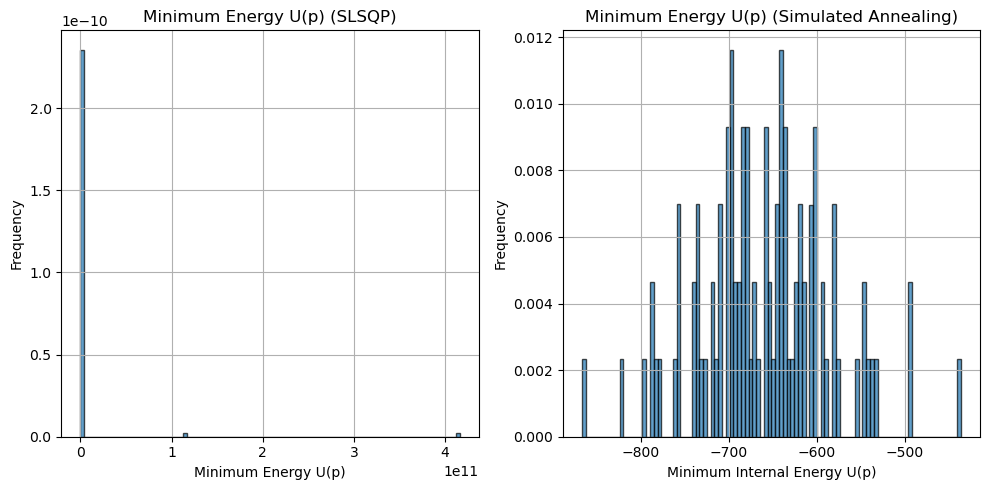

In [47]:
# Plotting the histograms side by side
plt.figure(figsize=(10, 5))

# Plotting SLSQP histogram
plt.subplot(1, 2, 1)
plt.hist(energies_optimization, bins=100, edgecolor='black', alpha=0.7, density=True, label='SLSQP')
plt.title('Minimum Energy U(p) (SLSQP)')
plt.xlabel('Minimum Energy U(p)')
plt.ylabel('Frequency')
plt.grid(True)

# Plotting Simulated Annealing histogram
plt.subplot(1, 2, 2)
plt.hist(energies_optimization_SA, bins=100, edgecolor='black', alpha=0.7, density=True, label='Simulated Annealing')
plt.title('Minimum Energy U(p) (Simulated Annealing)')
plt.xlabel('Minimum Internal Energy U(p)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define internal energy function
def energy_function(p, A):
    return np.sum(A * np.outer(p, p))

# Constraints for optimization
def probability_constraint(p):
    return np.sum(p) - 1.0

# Maximum Internal Energy using SLSQP
def maximum_internal_energy(initial_probabilities, A):
    # Optimization setup
    cons = ({'type': 'eq', 'fun': probability_constraint})
    bounds = [(0, 1) for _ in range(len(initial_probabilities))]

    # Perform optimization
    result = minimize(lambda p: -energy_function(p, A), initial_probabilities, method='SLSQP', bounds=bounds, constraints=cons)

    return result.x, -result.fun, result.fun

# Simulated Annealing for Internal Energy
def simulated_annealing_internal_energy(initial_probabilities, A, num_iterations=1000, initial_temperature=1.0, cooling_rate=0.95):
    current_probabilities = initial_probabilities
    current_energy = energy_function(current_probabilities, A)
    best_probabilities = current_probabilities
    best_energy = current_energy
    energy_history = [current_energy]

    for _ in range(num_iterations):
        temperature = initial_temperature * (cooling_rate ** _)

        # Generate a new set of probabilities
        new_probabilities = current_probabilities + np.random.normal(0, 0.1, len(current_probabilities))

        # Evaluate the energy of the new set of probabilities
        new_energy = energy_function(new_probabilities, A)

        # Accept the new set of probabilities with a probability based on the Metropolis criterion
        if np.random.rand() < np.exp((current_energy - new_energy) / temperature):
            current_probabilities = new_probabilities
            current_energy = new_energy

        # Update the best set of probabilities if needed
        if new_energy < best_energy:
            best_probabilities = new_probabilities
            best_energy = new_energy

        energy_history.append(current_energy)

    return best_probabilities, -best_energy, energy_history

# Example initial probabilities
list_size = 100
num_iterations = 1000

# Example symmetric matrix A
A = np.random.rand(list_size, list_size)
A = (A + A.T) / 2  # Make it symmetric

initial_probabilities = np.random.rand(list_size)

# Maximum Internal Energy using SLSQP
optimized_probabilities_slsqp, max_energy_slsqp, energy_history_slsqp = maximum_internal_energy(initial_probabilities, A)

# Simulated Annealing for Internal Energy
optimized_probabilities_annealing, max_energy_annealing, energy_history_annealing = simulated_annealing_internal_energy(initial_probabilities, A, num_iterations=num_iterations)

print(len(energy_history_slsqp))
print(len(energy_history_annealing))

# Plotting the energy versus iteration
plt.figure(figsize=(10, 5))

# Plotting SLSQP
plt.plot(range(num_iterations + 1), [max_energy_slsqp] + energy_history_slsqp[:-1], label='SLSQP Iterations', color='red')

# Plotting Simulated Annealing
plt.plot(range(num_iterations + 1), [max_energy_annealing] + energy_history_annealing[:-1], label='Simulated Annealing Iterations', color='blue')

plt.title('Energy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\cyril\AppData\Local\Temp\ipykernel_6464\1028144249.py:42: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp((current_energy - new_energy) / temperature):


TypeError: object of type 'numpy.float64' has no len()